# Modélisation 4 : Beam Search

## Introduction

Lors de cette itération, nous allons nous intéresser à l'application d'un Beam Search Decoder accouplé à un modèle Seq2Seq. Nous allons dans un premier temps importer un nouveau jeu de données. Comme nous l'avons vu lors de l'itération précédente, le jeu de données dont nous disposions était assez limité en terme de vocabulaire. En effet, le modèle se généralisait très mal et n'était performant que pour traduire les phrases qui ressemblait aux phrases du jeu de données. Afin d'avoir un point de comparaison avec un modèle Seq2Seq simple, nous allons d'abord entraîner le modèle de l'itération précédente avec le nouveau jeu de données, puis mettre au point un autre modèle Seq2Seq combiné cette fois-ci avec un Beam Search Decoder.

## Pré-traitement des données

In [1]:
# Import des packages
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RNN, Lambda, Embedding

import unicodedata
import re
import os
import io
import time

import random


# -*- coding: utf-8 -*-

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# Importation des données 
fr = pd.read_csv('french.txt', sep = "\n\n", names = ["Français"], encoding = 'utf-8', engine = 'python')
en = pd.read_csv('english.txt', sep = "\n\n", names = ["English"], encoding = 'utf-8', engine = 'python')
data = pd.concat([en, fr], axis=1)


In [3]:
# Nettoyage des données 

# Fonction de conversion d'un document d'unicode vers ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Prétraitement des phrases
def clean_sentence(w):
   
    # conversion unicode vers ascii
    w = unicode_to_ascii(w.lower().strip())

    # séparation entre un mot et sa ponctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # remplacement de caractères spéciaux par un espace
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # ajout des balises <start> et <end> placées respectivement au début et à la fin des phrases
    w = '<start> ' + w + ' <end>'
    
    return w

# Appliquer la fonction clean_sentence sur la colonne english
data.English = data.English.apply(lambda x: clean_sentence(x))

# Appliquer la fonction clean_sentence sur la colonne french
data.Français = data.Français.apply(lambda x: clean_sentence(x))

# Visulisation des 5 premières lignes
data.head()

,English,Français
0,<start> go . <end>,<start> va ! <end>
1,<start> run ! <end>,<start> cours ! <end>
2,<start> run ! <end>,<start> courez ! <end>
3,<start> fire ! <end>,<start> au feu ! <end>
4,<start> help ! <end>,<start> a l aide ! <end>


In [4]:
# Structuration des données 

def tokenize(sentences):
    # tokenization des phrases
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)

    # transformation des phrases en séquences
    seq = tokenizer.texts_to_sequences(sentences)
    
    # complète les séquences de sorte à ce qu'ils aient la même longueur
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq,padding='post')

    # post : le padding est réalisé à la fin des séquences
    return seq, tokenizer

# Tokenization(transforme une phrase en une liste de nombres qui correspondent chacun à un mot unique du vocabulaire)
input_seq, input_tokenizer = tokenize(data.English) # phrases tokenisées en fonction du vocabulaire anglais  
target_seq, target_tokenizer = tokenize(data.Français) # phrases tokenisées en fonction du vocabulaire français 
# input_tokenizer: est le tokenizer entraîné sur le jeu de données des phrases anglaises

# Calcul de la taille des vocabulaires via l'attribut .word_index qui transforme l'index d'un mot en sa chaîne de caractères 
vocab_size_inp = len(input_tokenizer.word_index)+1 # nombre de mots différents en français 
vocab_size_targ = len(target_tokenizer.word_index)+1 # nombre de mots différents en anglais 

# Calcul de longeur maximale des séquences 
max_length_inp, max_length_targ = input_seq.shape[1], target_seq.shape[1] 

print("Taille du vocabulaire :")
print(" - input :", vocab_size_inp)
print(" - target :", vocab_size_targ)

Taille du vocabulaire :
 - input : 13473
 - target : 22089


In [25]:
# Séparation des données en un ensemble d'apprentissage et de test

# Création des ensembles d'apprentissage et test
X_train, X_test, y_train, y_test = train_test_split(input_seq, target_seq,test_size=0.2)

# Paramètres de l'entrainement
# buffer_size: permet de déterminer combien d'éléments vont être mélangés au fur et à mesure, 

# batch_size: sépare dans l'ordre le dataset en jeux de données de dimension fixe
batch_size = 64
buffer_size = int(len(X_train)) 
steps_per_epoch = buffer_size//batch_size

# Création du dataset d'entrainement
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

# Affichage des deux composantes d'un jeu de données
example_input_batch, example_target_batch = next(iter(dataset))
print("Dimensions du batch input : ", example_input_batch.shape)
print("Dimensions du batch target : ", example_target_batch.shape)

Dimensions du batch input :  (64, 53)
Dimensions du batch target :  (64, 65)


## Construction du modèle Seq2Seq avec le nouveau jeu de données

### Encodeur 

Nous avons sélectionné un encodeur avec une couche embedding avec une matrice de dimension 300 et une couche GRU (gated recurrent unit) avec 512 neurones. 

In [106]:
# Définition de l'encodeur 

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim):
        # vocab_size: taille du vocabulaire dans la langue de départ
        # embedding_dim: dimension de la matrice d'embedding 
        # latent_dim : dimension de l'état caché (units)
        
        super(Encoder, self).__init__() # pour faciliter des questions d'héritage 
        
        self.units = latent_dim
        
        # sélection de l'embedding, fonction qui permet de vectoriser les mots représentés précédemment par leur index 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # sélection de la cellule de calcul GRU 
        self.gru = tf.keras.layers.GRU(self.units, # nombre d'états cachés - neurones  
                                       return_sequences=True, # retourne une séquence/ bidirectionelle
                                       return_state=True, # permet de conserver la mémoire de l'encodeur et le rend disponible pour le décodeur 
                                       recurrent_initializer='glorot_uniform') # initialisation des poids de la matrice utilisée pour la transformation linéaire des états récurrents par distribution uniforme 
      
    def call(self, x, hidden): # calcul des sorties du modèle 
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.units)) # définition d'une matrice de dim jeu de données fixé * nombre d'états cachés 


# Paramètres du modèle

latent_dim = 512 # nombre d'états cachés (2 puissance 9)
embedding_dim = 300 # dimension de la matrice d'embedding

encoder = Encoder(vocab_size_inp, embedding_dim, latent_dim)

hidden = encoder.initialize_hidden_state(batch_size) # état caché
enc_output, hidden = encoder(example_input_batch, hidden) # sortie

print('Dimensions de la sortie de l\'Encodeur : ')
print(' (batch size, max_length_inp, latent_dim) -> {}'.format(enc_output.shape))
print()

print('Dimensions de l\'état caché :')
print(' (batch size, latent_dim) -> {}'.format(hidden.shape))

Dimensions de la sortie de l'Encodeur : 
 (batch size, max_length_inp, latent_dim) -> (64, 53, 512)

Dimensions de l'état caché :
 (batch size, latent_dim) -> (64, 512)


### Mécanisme d'attention 

In [107]:
# définition de la classe 

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # définition de 3 couches de neuronnes denses 
        self.W1 = tf.keras.layers.Dense(units)# couche de l'état caché 
        self.W2 = tf.keras.layers.Dense(units) # couche de sortie de l'encodeur
        self.V = tf.keras.layers.Dense(1) # couche de sortie du mécanisme d'attention  

    def call(self, hidden, enc_output):
        # dimensions de 'hidden' : (batch_size, units)
        # dimensions de 'enc_output' : (batch_size, max_length_input, units)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # dimensions de 'hidden_with_time_axis' : (batch_size, 1, units)
        # ce changement de dimension est nécessaire pour le calcul du score
        
        # Application de la formule score = FC(tanh(FC(EO) + FC(H))
        # avec FC: couche Fully-connected (dense layer) c'est-à-dire W1 et W2
        # EO: sortie de l’Encodeur, encoder_output 
        # H : état caché, hidden_state. 

        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(enc_output)))
        # dimensions de 'score' : (batch_size, max_length_inp, 1)
        # dimensions avant d'appliquer 'self.V' : (batch_size, max_length_inp, units)

        # calcul des poids d'attention via la fonction softmax 
        attention_weights = tf.nn.softmax(score, axis=1)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)
        
        # calcul du vecteur contexte par produit scalaire
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # dimensions de context_vector après somme (batch_size, units)

        return context_vector, attention_weights

# paramétrage

attention_layer = BahdanauAttention(latent_dim)
attention_result, attention_weights = attention_layer(hidden, enc_output)

print("Dimensions de la sortie de la couche d'attention :")
print(" (batch size, latent_dim) {}".format(attention_result.shape))
print("Dimensions des poids d'attention :")
print(" (batch_size, max_length_inp, 1) {}".format(attention_weights.shape))


Dimensions de la sortie de la couche d'attention :
 (batch size, latent_dim) (64, 512)
Dimensions des poids d'attention :
 (batch_size, max_length_inp, 1) (64, 53, 1)


### Décodeur 

Le décodeur est constitué des mêmes couches que l'Encodeur avec la notion d'attention ajoutée. 

In [108]:
# Définition du décodeur 


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim, attention_layer):
        # même architecture que l'encodeur
        super(Decoder, self).__init__()
        
        self.units = latent_dim
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # couche dense comprenant le vocabulaire de la langue cible 
        self.fc = tf.keras.layers.Dense(vocab_size)

        # prise en compte de la notion d'attention en input du décodeur 
        self.attention = attention_layer(latent_dim)

    def call(self, x, hidden, enc_output):
        # dimensions de 'enc_output' : (batch_size, max_length_inp, latent_dim)
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # dimensions de 'context_vector' : (batch size, latent_dim)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)

        x = self.embedding(x)
        # dimensions de 'x' : (batch_size, 1, embedding_dim)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # dimensions de 'x' : (batch_size, 1, embedding_dim + latent_dim)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        # dimensions de 'output' : (batch_size * 1, latent_dim )

        output = self.fc(output)
        # dimensions de 'output' : (batch_size, vocab)

        return output, state, attention_weights

# paramétrage 

decoder = Decoder(vocab_size_targ, embedding_dim, latent_dim, BahdanauAttention)

dec_input = tf.random.uniform((batch_size, 1))
dec_output, _, _ = decoder(dec_input, hidden, enc_output)

print ('Dimension de la sortie du Décodeur :')
print(' (batch_size, vocab size) -> {}'.format(dec_output.shape))

Dimension de la sortie du Décodeur :
 (batch_size, vocab size) -> (64, 22089)


### Fonction de coût et optimiseur 

In [109]:
# Fonction de coût et optimiseur

def loss_function(real, pred):
    # calcul de l'entropie croisée à partir de la fonction logits entre la valeur réelle et la valeur prédite  
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    # masque de même taille que la séquence, qui contient 0 si la valeur de l'élement de la séquence est nulle, 1 sinon
    # ce masque permet de contrer l'effet du padding sur la fonction loss
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask # application de ce masque comme poids lors du calcul de l'erreur 
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam() # application de la méthode d'optimisation réalisée à partir de la fonction Adam 

## Entrainement du modèle 

In [10]:
"""# Entrainement du modèle 

@tf.function
def train_step(inp, targ, enc_initial_hidden):
    
    loss = 0 # initisalisation de la perte
    
    # utilisation d'une fonction de perte de Gradient 
    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_initial_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * batch_size, 1)

        # parcours de chaque élement de 'targ'
        for t in range(1, targ.shape[1]):
            
            # appel au Décodeur
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # calcul de la perte
            loss += loss_function(targ[:, t], predictions)

            # mise à jour de la variable 'dec_input'
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        
        # calcul des variables du modèle
        variables = encoder.trainable_variables + decoder.trainable_variables
    #calcul du gradient du modèle
    gradients = tape.gradient(loss, variables)
    # optimisation des variables du modèle
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss"""

In [11]:
"""# Evaluation des performances pendant l'entrainement du modèle 
# avec suivi de la fonction de perte tous les 100 batchs dans chaque époque

# Checkpoint - permet d'enregistrer le modèle
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp.ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

def train(n_epoch = 10):

    t=time.time()

    for epoch in range(n_epoch):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(batch_size)
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))

        # conservation du modèle tout les 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


    print("Time elapsed :{}s".format(round(time.time() - t,2)))

train(n_epoch = 10)
"""

Epoch 1 Batch 0 Loss 1.3994
Epoch 1 Batch 100 Loss 0.8208
Epoch 1 Batch 200 Loss 0.6995
Epoch 1 Batch 300 Loss 0.6811
Epoch 1 Batch 400 Loss 0.6407
Epoch 1 Batch 500 Loss 0.5771
Epoch 1 Batch 600 Loss 0.6083
Epoch 1 Batch 700 Loss 0.5530
Epoch 1 Batch 800 Loss 0.5415
Epoch 1 Batch 900 Loss 0.5397
Epoch 1 Batch 1000 Loss 0.4662
Epoch 1 Batch 1100 Loss 0.5053
Epoch 1 Batch 1200 Loss 0.4646
Epoch 1 Batch 1300 Loss 0.4169
Epoch 1 Batch 1400 Loss 0.4597
Epoch 1 Batch 1500 Loss 0.4696
Epoch 1 Batch 1600 Loss 0.4230
Epoch 1 Batch 1700 Loss 0.4386
Epoch 1 Batch 1800 Loss 0.4011
Epoch 1 Batch 1900 Loss 0.3625
Epoch 1 Loss 0.5445
Time taken for 1 epoch 828.79 sec

Epoch 2 Batch 0 Loss 0.3014
Epoch 2 Batch 100 Loss 0.3884
Epoch 2 Batch 200 Loss 0.3649
Epoch 2 Batch 300 Loss 0.3478
Epoch 2 Batch 400 Loss 0.2817
Epoch 2 Batch 500 Loss 0.2977
Epoch 2 Batch 600 Loss 0.3292
Epoch 2 Batch 700 Loss 0.3270
Epoch 2 Batch 800 Loss 0.3053
Epoch 2 Batch 900 Loss 0.3180
Epoch 2 Batch 1000 Loss 0.2708
Epoch 2 

## Chargement du modèle

In [110]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp.ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Traduction

In [111]:
# Définition de la fonction de traduction 

def translate(sentence, is_seq = False):
    
    # Initialisation de la matrice d'attention
    attention_matrix = np.zeros((max_length_targ, max_length_inp))    
    
    # permet de transformer l'entrée sous forme de phrase en séquence (pour de nouvelles phrases non séquencées)
    if not(is_seq):
        # prétraitement de la phrase d'entrée
        sentence = clean_sentence(sentence)
        # transformation de la phrase en séquence
        sentence = input_tokenizer.texts_to_sequences([sentence])
        sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,
                                                             maxlen=max_length_inp,
                                                             padding='post')
        
    # initialisation des variables
    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(sentence, hidden)
    dec_hidden = enc_hidden
    
    # remplissage du premier élement par l'indice associé à la balise <start>
    dec_input = tf.expand_dims([input_tokenizer.word_index['<start>']], 0)

    stop_condition = False # initialisation du status de la traduction -> True correspond à la balise <"end">
    words = [] # initialisation de la phrase de sortie
    t = 0

    while not stop_condition:
        
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # conservation des poids d'attention
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()
        
        # utilisation du mot ayant la meilleure probabilité pour la prédiction 
        predicted_index = tf.argmax(predictions[0]).numpy()
        
        if predicted_index != 0:
            word = target_tokenizer.index_word[predicted_index]
        else :
            word = ''

        # retour de la prédiction id dans le modèle 
        dec_input = tf.expand_dims([predicted_index], 0)
        
        # verification des conditions de sortie: 
        if (word == '<end>' or # la balise <end> 
           t >= max_length_targ-1): # longeur maximale atteinte
            
            stop_condition = True
            break
            
         # ajout du mot à la phrase de sortie    
        words.append(word)
        
        t+=1

    return " ".join(words), attention_matrix

In [114]:
translate("United States is rainy.")

('les etats unis est pluvieux .',
 array([[6.92999065e-02, 4.39389586e-01, 3.09402227e-01, ...,
         2.10158364e-03, 2.09905999e-03, 2.09666323e-03],
        [3.49451415e-02, 5.24549961e-01, 3.13057631e-01, ...,
         9.25402201e-05, 9.25343993e-05, 9.25287459e-05],
        [4.70855981e-02, 3.27038378e-01, 3.46358865e-01, ...,
         3.57802201e-05, 3.58014513e-05, 3.58226935e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))

In [22]:
"""# Application de la fonction de traduction sur données de tests 

from tqdm import tqdm

def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test[i], input_tokenizer)
        y_pred, attention_matrix = translate(X_test[i].reshape((-1,max_length_inp)), is_seq = True)
        y_true = find_sentence(y_test[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
    
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_greedy2.csv', index=False)
        
test(len(X_test))"""


100%|██████████| 30977/30977 [38:14<00:00, 13.50it/s]  


## Evaluation des résultats 

In [3]:
# imports nécessaires 
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
import re

# récupération des résultats sous forme d'un dataframe 
df_results=pd.read_csv('results_mod4_greedy2.csv')

# retrait des balises <start> et <end> de la colonne "Phrase_traduite"
phrase_purgee=[]
for phrase in df_results['Phrase_traduite']:
    phrase = phrase.replace('<start>','')
    phrase = phrase.replace('<end>', '')
    phrase_purgee.append(phrase)
df_results['Phrase_traduite']=phrase_purgee    

df_results.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhedh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Phrase_a_traduire,Phrase_traduite,Sortie_modele
0,<start> they can add something if they wish ....,ils peuvent ajouter autre chose s ils le sou...,ils peuvent savoir quelque chose si elles le s...
1,<start> my father stopped smoking . <end>,mon pere a arrete de fumer .,mon pere a arrete de fumer .
2,<start> she will report directly to me . <end>,elle me sera directement rattachee .,elle me sera directement rattachee .
3,"<start> he not only speaks french , but he sp...","il ne parle pas seulement en francais , mais...","il ne parle pas seulement le francais , mais a..."
4,<start> i can follow the rules . <end>,je peux suivre les regles .,je peux suivre les regles .


Evaluer les résultats entre la "Phrase_traduite" et la phrase "Sortie_modele" n'est pas immédiat car celles-ci peuvent être différentes mais correspondre toutes deux à une traduction possible. Il est également difficile de juger de la syntaxe et de l'orthographe des phrases. 

Nous avons utilisé deux indicateurs pour tenter de mieux comprendre les résultats: 
- vérification du nombre de mots dans chaque des phrases
- comparaison des racinisation des mots de chaque des phrases

### Vérification du nombre de mots dans chaque des phrases

In [4]:
# Création d'une colonne 'Nb_words_cible' fournissant le nombre de mots dans la phrase cible 
nb_words_cible=[]
for sentence in df_results['Phrase_traduite']:
    nb_words_cible.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_cible']=nb_words_cible

# Création d'une colonne 'Nb_words_mod' fournissant le nombre de mots dans la phrase prédite par le modèle 
nb_words_mod=[]
for sentence in df_results['Sortie_modele']:
    nb_words_mod.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_mod']=nb_words_mod

# Création d'une colonne diff
df_results['Différence']=df_results['nb_words_cible']-df_results['nb_words_mod']

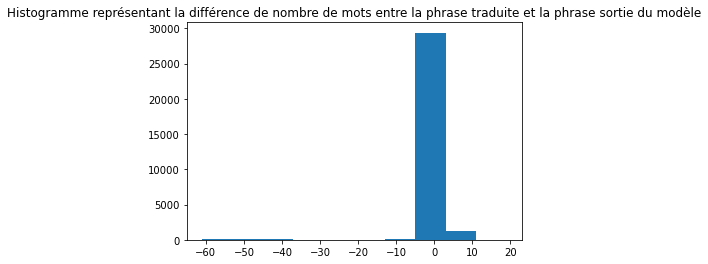

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_results.Différence)
plt.title("Histogramme représentant la différence de nombre de mots entre la phrase traduite et la phrase sortie du modèle"); 

In [6]:
print("La majorité des phrases sorties du modèle, soit", 
      round(len(df_results.loc[(df_results.Différence <= 1)&(df_results.Différence >= -1)])/df_results.shape[0]*100, 2),  
      "%, ne présente au plus qu'un mot d'écart avec la phrase traduite.")

La majorité des phrases sorties du modèle, soit 83.57 %, ne présente au plus qu'un mot d'écart avec la phrase traduite.


Cet histogramme montre qu'une très grande partie des phrases contiennent le même nombre de mots dans les deux cas.  

### Comparaison des racinisation des mots de chaque des phrases

In [7]:
# Importer stopwords de la classe nltk.corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Initialisation de la liste des mots vides en français puis ajout de certains mots 
stop_words = set(stopwords.words('french'))
stop_words.update([",", ".", ":", ";", "!", "?"])

# Intialisation de la racinisation en français 
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhedh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Application à tout le dataframe 

# Instanciation des listes nécessaires 
racine_cible_tot=[]
racine_cible=[]
racine_mod_tot=[]
racine_mod=[]

# Création d'une colonne 'racine_cible' fournissant la liste des racines des mots des phrases de la colonne cible 
for sentence in df_results['Phrase_traduite']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
        racine_cible.append(stemmer.stem(mot))
    if len(racine_cible) != 0:
        racine_cible_tot.append(racine_cible)
        racine_cible=[]
    else :
        racine_cible_tot.append('abc')
    
df_results['racine_cible']=racine_cible_tot

# rajout des guillemets 
df_results['racine_cible'] = [[f'"{j}"' for j in i] for i in df_results['racine_cible']]


# Création d'une colonne 'racine_mod' fournissant la liste des racines des mots des phrases de la colonne prédite par le modèle  
for sentence in df_results['Sortie_modele']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
        racine_mod.append(stemmer.stem(mot))
    racine_mod_tot.append(racine_mod)
    racine_mod=[]

df_results['racine_mod']=racine_mod_tot

# rajout des guillemets 
df_results['racine_mod'] = [[f'"{j}"' for j in i] for i in df_results['racine_mod']]

df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,nb_words_cible,nb_words_mod,Différence,racine_cible,racine_mod
0,<start> they can add something if they wish ....,ils peuvent ajouter autre chose s ils le sou...,ils peuvent savoir quelque chose si elles le s...,10,10,0,"[""il"", ""peuvent"", ""ajout"", ""autr"", ""chos"", ""s""...","[""il"", ""peuvent"", ""savoir"", ""quelqu"", ""chos"", ..."
1,<start> my father stopped smoking . <end>,mon pere a arrete de fumer .,mon pere a arrete de fumer .,7,7,0,"[""mon"", ""per"", ""a"", ""arret"", ""de"", ""fum"", "".""]","[""mon"", ""per"", ""a"", ""arret"", ""de"", ""fum"", "".""]"
2,<start> she will report directly to me . <end>,elle me sera directement rattachee .,elle me sera directement rattachee .,6,6,0,"[""elle"", ""me"", ""ser"", ""direct"", ""rattache"", "".""]","[""elle"", ""me"", ""ser"", ""direct"", ""rattache"", "".""]"
3,"<start> he not only speaks french , but he sp...","il ne parle pas seulement en francais , mais...","il ne parle pas seulement le francais , mais a...",13,12,1,"[""il"", ""ne"", ""parl"", ""pas"", ""seul"", ""en"", ""fra...","[""il"", ""ne"", ""parl"", ""pas"", ""seul"", ""le"", ""fra..."
4,<start> i can follow the rules . <end>,je peux suivre les regles .,je peux suivre les regles .,6,6,0,"[""je"", ""peux"", ""suivr"", ""le"", ""regl"", "".""]","[""je"", ""peux"", ""suivr"", ""le"", ""regl"", "".""]"


### Etablissement des scores 

Nous avons crée deux scores permettant de calculer un score total par la moyenne des deux premiers. 

Le premier score correspond au ratio du nombre de racines en commun sur le nombre de racines des phrases cibles. 

Le second score correspond à un calcul lié au nombre de mots d'écart entre les phrases traduites et les phrases sorties du modèle. Pour une phrase sans mot d'écart, le score sera de 1 et ce score diminue avec l'augmentation du nombre de mots d'écart. 

In [9]:
# Création d'une colonne "comparaison racine" fournissant le ratio 
#nombre de racines en commun / nombre de racines des phrases cibles

# Création d'une colonne "comparaison différence" fournissant le ratio 
#différence du nombre de mots / nombre de mots cibles

score_racine=[]
score_difference = []
for i in range(df_results.shape[0]):
    score_racine.append(len(set(df_results.iloc[i,6]) & set(df_results.iloc[i,7]))/len(df_results.iloc[i,6]))
    if (abs(df_results.iloc[i, 5])/df_results.iloc[i,3]) > 1:
        score_diff = 0
    else :
        score_diff = 1 - abs(df_results.iloc[i, 5])/df_results.iloc[i,3]
    score_difference.append(score_diff)
    
df_results['score_racine']=score_racine

df_results['score_diff']= score_difference

df_results['score_tot']=(df_results['score_diff']+ df_results['score_racine'])/2


In [10]:
df_results = df_results.drop(["nb_words_cible", "nb_words_mod", "Différence", "racine_cible", "racine_mod"], axis = 1)
df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot
0,<start> they can add something if they wish ....,ils peuvent ajouter autre chose s ils le sou...,ils peuvent savoir quelque chose si elles le s...,0.500000,1.000000,0.750000
1,<start> my father stopped smoking . <end>,mon pere a arrete de fumer .,mon pere a arrete de fumer .,1.000000,1.000000,1.000000
2,<start> she will report directly to me . <end>,elle me sera directement rattachee .,elle me sera directement rattachee .,1.000000,1.000000,1.000000
3,"<start> he not only speaks french , but he sp...","il ne parle pas seulement en francais , mais...","il ne parle pas seulement le francais , mais a...",0.846154,0.923077,0.884615
4,<start> i can follow the rules . <end>,je peux suivre les regles .,je peux suivre les regles .,1.000000,1.000000,1.000000


In [11]:
# Calcul de la moyenne du score_tot

print("moyenne du score_racine", df_results['score_racine'].mean())
print("moyenne du score_diff", df_results['score_diff'].mean())
print("Score du modèle au test de performance", df_results['score_tot'].mean())

moyenne du score_racine 0.7895969934571637
moyenne du score_diff 0.9157793900759424
Score du modèle au test de performance 0.8526881917665909


### Score BLEU

In [12]:
from nltk.translate.bleu_score import sentence_bleu
score_bleu = []
for i in range(df_results.shape[0]):
    reference = [''.join(df_results.iloc[i, 1]).split()]
    candidate = ''.join(df_results.iloc[i, 2]).split()
    score_bleu.append(sentence_bleu(reference, candidate, weights = (1,0,0,0)))
df_results["Score_bleu"] = score_bleu
df_results.head()

C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot,Score_bleu
0,<start> they can add something if they wish ....,ils peuvent ajouter autre chose s ils le sou...,ils peuvent savoir quelque chose si elles le s...,0.500000,1.000000,0.750000,0.500000
1,<start> my father stopped smoking . <end>,mon pere a arrete de fumer .,mon pere a arrete de fumer .,1.000000,1.000000,1.000000,1.000000
2,<start> she will report directly to me . <end>,elle me sera directement rattachee .,elle me sera directement rattachee .,1.000000,1.000000,1.000000,1.000000
3,"<start> he not only speaks french , but he sp...","il ne parle pas seulement en francais , mais...","il ne parle pas seulement le francais , mais a...",0.846154,0.923077,0.884615,0.843374
4,<start> i can follow the rules . <end>,je peux suivre les regles .,je peux suivre les regles .,1.000000,1.000000,1.000000,1.000000


In [13]:
# Score BLEU du modèle : 
print("Score BLEU du modèle", df_results['Score_bleu'].mean())

Score BLEU du modèle 0.7554051591860872


### Score ROUGE

In [14]:
from rouge import Rouge

r = Rouge()
precision_col = []
recall_col = []
fscore_col = []

for i in range(df_results.shape[0]):
    reference = df_results.iloc[i, 1]
    candidate = df_results.iloc[i, 2]
    score_rouge = r.get_scores(candidate, reference)
    precision_col.append(score_rouge[0]['rouge-1']['p'])
    recall_col.append(score_rouge[0]['rouge-1']['r'])
    fscore_col.append(score_rouge[0]['rouge-1']['f'])

df_results['Rouge_recall'] = recall_col
df_results['Rouge_precision'] = precision_col
df_results['Rouge_f1_score'] = fscore_col

In [15]:
# Score ROUGE du modèle : 
print("Score ROUGE recall du modèle", df_results['Rouge_recall'].mean())
print("Score ROUGE precision du modèle", df_results['Rouge_precision'].mean())
print("Score ROUGE f1_score du modèle", df_results['Rouge_f1_score'].mean())

Score ROUGE recall du modèle 0.6772868511564343
Score ROUGE precision du modèle 0.770816946125865
Score ROUGE f1_score du modèle 0.71710511002731


In [16]:
df_results = df_results.drop(["score_racine", "score_diff", "Rouge_recall", "Rouge_precision"], axis = 1)

In [17]:
df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_tot,Score_bleu,Rouge_f1_score
0,<start> they can add something if they wish ....,ils peuvent ajouter autre chose s ils le sou...,ils peuvent savoir quelque chose si elles le s...,0.750000,0.500000,0.444444
1,<start> my father stopped smoking . <end>,mon pere a arrete de fumer .,mon pere a arrete de fumer .,1.000000,1.000000,0.923077
2,<start> she will report directly to me . <end>,elle me sera directement rattachee .,elle me sera directement rattachee .,1.000000,1.000000,0.909091
3,"<start> he not only speaks french , but he sp...","il ne parle pas seulement en francais , mais...","il ne parle pas seulement le francais , mais a...",0.884615,0.843374,0.869565
4,<start> i can follow the rules . <end>,je peux suivre les regles .,je peux suivre les regles .,1.000000,1.000000,0.909091


## Création d'un modèle pour le Beam Search Decoder

### Paramètres d'entrainements et du modèle 

In [6]:
vocab_inp_size = vocab_size_inp
vocab_tar_size = vocab_size_targ
max_length_input = max_length_inp
max_length_output = max_length_targ

BATCH_SIZE = 64
units = 1024 # nombre d'états cachés (2 puissance 10)
embedding_dim_beam = 256 # dimension de la matrice d'embedding
steps_per_epoch = buffer_size//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 65]))

### Encodeur

Nous avons choisi ici un encodeur avec une couche d'embedding de dimension 256 et une couche LSTM (long short-term memory) avec 1024 neurones.

In [7]:
class Encoder_beam(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim_beam, enc_units, batch_sz):
        # vocab_size: taille du vocabulaire dans la langue de départ
        # embedding_dim_beam: dimension de la matrice d'embedding 
        # enc_units : dimension de l'état caché (units)
        #batch_sz = batch size
        super(Encoder_beam, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        # sélection de l'embedding, fonction qui permet de vectoriser les mots représentés précédemment par leur index
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim_beam)
       

        # sélection de la cellule de calcul LSTM
        self.lstm_layer = tf.keras.layers.LSTM(self.enc_units, # nombre d'états cachés - neurones
                                       return_sequences=True,  # retourne une séquence/ bidirectionelle
                                       return_state=True,  # permet de conserver la mémoire de l'encodeur et le rend disponible pour le décodeur
                                       recurrent_initializer='glorot_uniform')# initialisation des poids de la matrice utilisée pour la transformation linéaire des états récurrents par distribution uniforme

    def call(self, x, hidden):
        x = self.embedding(x)
        output, h, c = self.lstm_layer(x, initial_state = hidden)
        return output, h, c

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

encoder_beam = Encoder_beam(vocab_inp_size, embedding_dim_beam, units, BATCH_SIZE)


sample_hidden = encoder_beam.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder_beam(example_input_batch, sample_hidden)
print ("Dimensions de la sortie de l'Encodeur : (batch size, sequence length, units) {}".format(sample_output.shape))
print ("Dimensions du veceur h de l'Encodeur: (batch size, units) {}".format(sample_h.shape))
print ("Dimensions du vecteur c de l'Encodeur: (batch size, units) {}".format(sample_c.shape))

Dimensions de la sortie de l'Encodeur : (batch size, sequence length, units) (64, 53, 1024)
Dimensions du veceur h de l'Encodeur: (batch size, units) (64, 1024)
Dimensions du vecteur c de l'Encodeur: (batch size, units) (64, 1024)


### Décodeur

Nous construisons ensuite le décodeur. Ici, nous n'aurons pas à créer une classe pour le mécanisme d'attention au préalable car nous utiliserons le module tensorflow-addons qui permet d'appliquer directement le mécanisme d'attention désiré.

In [8]:


class Decoder_beam(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim_beam, dec_units, batch_sz, attention_type='luong'):
        super(Decoder_beam, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.attention_type = attention_type

        # Embedding Layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim_beam)

        #Final Dense layer on which softmax will be applied
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Define the fundamental cell for decoder recurrent structure
        self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)



        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()

        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                                  None, self.batch_sz*[max_length_input], self.attention_type)

        # Wrap attention mechanism with the fundamental rnn cell of decoder
        self.rnn_cell = self.build_rnn_cell(batch_sz)

        # Define the decoder with respect to fundamental rnn cell
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)


    def build_rnn_cell(self, batch_sz):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                      self.attention_mechanism, attention_layer_size=self.dec_units)
        return rnn_cell

    def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='bahdanau'):
        # ------------- #
        # typ: Which sort of attention (Bahdanau, Luong)
        # dec_units: final dimension of attention outputs 
        # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
        # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

        if(attention_type=='bahdanau'):
            return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
        else:
            return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

    def build_initial_state(self, batch_sz, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
        return decoder_initial_state


    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
        return outputs
    

decoder_beam = Decoder_beam(vocab_tar_size, embedding_dim_beam, units, BATCH_SIZE, 'luong')
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder_beam.attention_mechanism.setup_memory(sample_output)
initial_state = decoder_beam.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


sample_decoder_outputs = decoder_beam(sample_x, initial_state)

print("Dimension de sortie du Decodeur: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 64, 22089)


### Fonction de coût et optimiseur

In [9]:
optimizer = tf.keras.optimizers.Adam() 


checkpoint_dir_beam = './training_checkpoints_beam'
checkpoint_prefix = os.path.join(checkpoint_dir_beam, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder_beam,
                                 decoder=decoder_beam)

@tf.function
def train_step_beam(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_h, enc_c = encoder_beam(inp, enc_hidden)


        dec_input = targ[ : , :-1 ] # Ignore <end> token
        real = targ[ : , 1: ]         # ignore <start> token

        # Set the AttentionMechanism object with encoder_outputs
        decoder_beam.attention_mechanism.setup_memory(enc_output)

        # Create AttentionWrapperState as initial_state for decoder
        decoder_initial_state = decoder_beam.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
        pred = decoder_beam(dec_input, decoder_initial_state)
        logits = pred.rnn_output
        loss = loss_function(real, logits)

    variables = encoder_beam.trainable_variables + decoder_beam.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss


### Entrainement du modèle 

In [30]:
"""EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder_beam.initialize_hidden_state()
    total_loss = 0
    # print(enc_hidden[0].shape, enc_hidden[1].shape)
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step_beam(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))"""

Epoch 1 Batch 0 Loss 1.3995
Epoch 1 Batch 100 Loss 0.7648
Epoch 1 Batch 200 Loss 0.7159
Epoch 1 Batch 300 Loss 0.6033
Epoch 1 Batch 400 Loss 0.5686
Epoch 1 Batch 500 Loss 0.5188
Epoch 1 Batch 600 Loss 0.5164
Epoch 1 Batch 700 Loss 0.5136
Epoch 1 Batch 800 Loss 0.4599
Epoch 1 Batch 900 Loss 0.4005
Epoch 1 Batch 1000 Loss 0.4163
Epoch 1 Batch 1100 Loss 0.4242
Epoch 1 Batch 1200 Loss 0.3767
Epoch 1 Batch 1300 Loss 0.3736
Epoch 1 Batch 1400 Loss 0.3222
Epoch 1 Batch 1500 Loss 0.3577
Epoch 1 Batch 1600 Loss 0.3192
Epoch 1 Batch 1700 Loss 0.2799
Epoch 1 Batch 1800 Loss 0.2819
Epoch 1 Batch 1900 Loss 0.2813
Epoch 1 Loss 0.4681
Time taken for 1 epoch 1215.6163401603699 sec

Epoch 2 Batch 0 Loss 0.2539
Epoch 2 Batch 100 Loss 0.2688
Epoch 2 Batch 200 Loss 0.2887
Epoch 2 Batch 300 Loss 0.2520
Epoch 2 Batch 400 Loss 0.2220
Epoch 2 Batch 500 Loss 0.2577
Epoch 2 Batch 600 Loss 0.2174
Epoch 2 Batch 700 Loss 0.2259
Epoch 2 Batch 800 Loss 0.2420
Epoch 2 Batch 900 Loss 0.3061
Epoch 2 Batch 1000 Loss 0.2

KeyboardInterrupt: 

In [31]:
"""print('time elapsed : 12092s')"""

time elapsed : 12092s


### Chargement du modèle

In [10]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_beam))

### Traduction avec le Beam Search Decoder

Nous créons ici deux fonction :

-beam_evaluate_sentences qui prendra en entrée une phrase à traduire et un paramètre k, qui appliquera le principe du Beam Search decoder grâce à la fonction du même nom du module Tensorflow-addons et qui donnera en sortie les k vecteurs ayant le plus de probabilité d'êtres les tradcutions de la phrase en entrée ainsi que ces dites probabilités.

-beam_translate qui prendra en entrée une phrase vectorisée et qui convertira ces vecteurs en phrases en utilisant la méthode sequences_to_text du tokenizer utilisé pour vectoriser les phrases.


In [12]:
def beam_evaluate_sentence(sentence, beam_width=5):
    
    sentence = sentence.replace('<start>','')
    sentence = sentence.replace('<end>', '')
    sentence = clean_sentence(sentence)
    

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    result = ''

    enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
    enc_out, enc_h, enc_c = encoder_beam(inputs, enc_start_state)

    dec_h = enc_h
    dec_c = enc_c

    start_tokens = tf.fill([inference_batch_size], target_tokenizer.word_index['<start>'])
    end_token = target_tokenizer.word_index['<end>']

    enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
    decoder_beam.attention_mechanism.setup_memory(enc_out)
    #print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] :", enc_out.shape)

    # set decoder_inital_state which is an AttentionWrapperState considering beam_width
    hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
    decoder_initial_state = decoder_beam.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
    decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)

    # Instantiate BeamSearchDecoder
    decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder_beam.rnn_cell,beam_width=beam_width, output_layer=decoder_beam.fc)
    decoder_embedding_matrix = decoder_beam.embedding.variables[0]

    # The BeamSearchDecoder object's call() function takes care of everything.
    outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
    # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
    # The final beam predictions are stored in outputs.predicted_id
    # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
    # final_state = tfa.seq2seq.BeamSearchDecoderState object.
    # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated


    # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
    # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
    # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
    final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
    beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))

    return final_outputs.numpy(), beam_scores.numpy()

In [13]:
def beam_translate(sentence):
    result, beam_scores = beam_evaluate_sentence(sentence)
    #print(result.shape, beam_scores.shape)
    for beam, score in zip(result, beam_scores):
        #print(beam.shape, score.shape)
        output = target_tokenizer.sequences_to_texts(beam)
        output = [a[:a.index('<end>')] for a in output]
        beam_score = [a.sum() for a in score]
        #print('Input: %s' % (sentence))
        #for i in range(len(output)):
            #print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))
    return output[0]

In [14]:
beam_translate("The translation of this sentence will be correct.")

'la traduction de cette phrase sera correcte . '

In [15]:
# Application de la fonction de traduction sur données de tests 

"""from tqdm import tqdm
X_test0 = X_test[:7750]
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test0[i], input_tokenizer)
        y_pred = beam_translate(x_test)
        y_true = find_sentence(y_test[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_beam0.csv', index=False)
       
    
test(len(X_test0))"""

100%|██████████| 7750/7750 [22:17<00:00,  5.79it/s]


In [16]:
# Application de la fonction de traduction sur données de tests 

"""from tqdm import tqdm
X_test1= X_test[7750:15500]
y_test1=y_test[7750:15500]
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test1[i], input_tokenizer)
        y_pred = beam_translate(x_test)
        y_true = find_sentence(y_test1[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
        
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_beam1.csv', index=False)
       
    
test(len(X_test1))"""

100%|██████████| 7750/7750 [22:43<00:00,  5.68it/s]  


In [17]:
# Application de la fonction de traduction sur données de tests 

"""from tqdm import tqdm

X_test2= X_test[15500:23050]
y_test2=y_test[15500:23050]
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test2[i], input_tokenizer)
        y_pred = beam_translate(x_test)
        y_true = find_sentence(y_test2[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
       
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_beam2.csv', index=False)
       
    
test(len(X_test2))"""

100%|██████████| 7550/7550 [22:59<00:00,  5.47it/s]  


In [20]:
# Application de la fonction de traduction sur données de tests 

"""from tqdm import tqdm
X_test3=X_test[23050:27014]
y_test3=y_test[23050:27014]
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test3[i], input_tokenizer)
        y_pred = beam_translate(x_test)
        y_true = find_sentence(y_test3[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
        
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_beam3.csv', index=False)
       
    
test(len(X_test3))"""

  1%|▏         | 53/3964 [00:09<13:02,  5.00it/s]

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_addons\seq2seq\decoder.py", line 485, in body
    next_sequence_lengths,  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_core\python\util\nest.py", line 569, in map_structure
    expand_composites=expand_composites)  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_core\python\util\nest.py", line 568, in <listcomp>
    structure[0], [func(*x) for x in entries],  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_addons\seq2seq\decoder.py", line 477, in <lambda>
    lambda ta, out: ta.write(time, out), outputs_ta, emit  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tens

100%|██████████| 3964/3964 [12:42<00:00,  5.20it/s]


In [26]:
"""# Application de la fonction de traduction sur données de tests 

from tqdm import tqdm
X_test4=X_test[27014:]
y_test4=y_test[27014:]
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])

    for i in tqdm(range(n_test)):

        x_test = find_sentence(X_test4[i], input_tokenizer)
        y_pred = beam_translate(x_test)
        y_true = find_sentence(y_test4[i], target_tokenizer)
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
        
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_beam4.csv', index=False)
       
    
test(len(X_test4))"""

 29%|██▊       | 1135/3963 [03:39<09:31,  4.95it/s]

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_addons\seq2seq\decoder.py", line 485, in body
    next_sequence_lengths,  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_core\python\util\nest.py", line 569, in map_structure
    expand_composites=expand_composites)  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_core\python\util\nest.py", line 568, in <listcomp>
    structure[0], [func(*x) for x in entries],  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tensorflow_addons\seq2seq\decoder.py", line 477, in <lambda>
    lambda ta, out: ta.write(time, out), outputs_ta, emit  File "C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\tens

100%|██████████| 3963/3963 [13:10<00:00,  5.01it/s]  


##  Evaluation des résultats

In [64]:
# imports nécessaires 

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
import re

# récupération des résultats sous forme d'un dataframe 
beam0=pd.read_csv('results_mod4_beam0.csv')   
beam1=pd.read_csv('results_mod4_beam1.csv')
beam2=pd.read_csv('results_mod4_beam2.csv')
beam3=pd.read_csv('results_mod4_beam3.csv')
beam4=pd.read_csv('results_mod4_beam4.csv')
df_results_beam = pd.concat([beam0, beam1, beam2, beam3, beam4], ignore_index=True)

phrase_purgee=[]
for phrase in df_results_beam['Phrase_traduite']:
    phrase = phrase.replace('<start>','')
    phrase = phrase.replace('<end>', '')
    phrase_purgee.append(phrase)
df_results_beam['Phrase_traduite']=phrase_purgee    

df_results_beam.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mouni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Phrase_a_traduire,Phrase_traduite,Sortie_modele
0,<start> i love fried bananas . <end>,j adore les bananes frites .,j adore les bananes frites .
1,<start> i want to be alone for a while . <end>,je veux etre seule un moment .,je veux etre seul un moment .
2,<start> i could never do that sort of thing ....,ce genre de chose ne m etait encore jamais a...,je ne pourrais jamais faire ce type de chose .
3,<start> i was offered the choice of tea or co...,on m a propose le choix entre un the et un c...,on m a propose le choix entre un cafe .
4,<start> are you at home ? <end>,tu es chez toi ?,etes vous chez vous ?


### Vérification du nombre de mots dans chaque phrase

In [65]:
# Création d'une colonne 'Nb_words_cible' fournissant le nombre de mots dans la phrase cible 
nb_words_cible=[]
for sentence in df_results_beam['Phrase_traduite']:
    nb_words_cible.append(len(word_tokenize(sentence, language='french')))
df_results_beam['nb_words_cible']=nb_words_cible

# Création d'une colonne 'Nb_words_mod' fournissant le nombre de mots dans la phrase prédite par le modèle 
nb_words_mod=[]
for sentence in df_results_beam['Sortie_modele']:
    nb_words_mod.append(len(word_tokenize(sentence, language='french')))
df_results_beam['nb_words_mod']=nb_words_mod

# Création d'une colonne diff
df_results_beam['Différence']=df_results_beam['nb_words_cible']-df_results_beam['nb_words_mod']

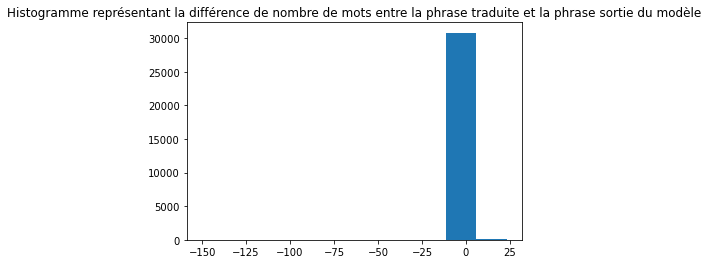

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_results_beam.Différence)
plt.title("Histogramme représentant la différence de nombre de mots entre la phrase traduite et "
          "la phrase sortie du modèle");

In [68]:
print("La majorité des phrases sorties du modèle, soit", 
      round(len(df_results_beam.loc[(df_results_beam.Différence <= 1)&(df_results_beam.Différence >= -1)])/df_results_beam.shape[0]*100, 2),  
      "%, présente au plus 1 mots d'écart avec la phrase traduite.")

La majorité des phrases sorties du modèle, soit 86.77 %, présente au plus 1 mots d'écart avec la phrase traduite.


### Comparaison des racinisation des mots de chaque des phrases

In [69]:
# imports nécessaires 
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
import re

# récupération des résultats sous forme d'un dataframe

# retrait des balises <start> et <end> de la colonne "Phrase_traduite"
phrase_purgee=[]
for phrase in df_results_beam['Phrase_traduite']:
    phrase = phrase.replace('<start>','')
    phrase = phrase.replace('<end>', '')
    phrase_purgee.append(phrase)
df_results_beam['Phrase_traduite']=phrase_purgee    

df_results_beam.head()

import nltk
from nltk.tokenize import word_tokenize
 
stop_words = set([",", ".", "?", "!", ":", ";"])

# Intialisation de la racinisation en français 
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

# Application à tout le dataframe 

# Instanciation des listes nécessaires 
racine_cible_tot=[]
racine_cible=[]
racine_mod_tot=[]
racine_mod=[]

# Création d'une colonne 'racine_cible' fournissant la liste des racines des mots des phrases de la colonne cible 
for sentence in df_results_beam['Phrase_traduite']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
            racine_cible.append(stemmer.stem(mot))
    if len(racine_cible) != 0:
        racine_cible_tot.append(racine_cible)
        racine_cible=[]
    else :
        racine_cible_tot.append('abc')
    
df_results_beam['racine_cible']=racine_cible_tot

# rajout des guillemets 
df_results_beam['racine_cible'] = [[f'"{j}"' for j in i] for i in df_results_beam['racine_cible']]


# Création d'une colonne 'racine_mod' fournissant la liste des racines des mots des phrases de la colonne prédite par le modèle  
for sentence in df_results_beam['Sortie_modele']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
            racine_mod.append(stemmer.stem(mot))
    racine_mod_tot.append(racine_mod)
    racine_mod=[]

df_results_beam['racine_mod']=racine_mod_tot

# rajout des guillemets 
df_results_beam['racine_mod'] = [[f'"{j}"' for j in i] for i in df_results_beam['racine_mod']]

df_results_beam.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mouni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Phrase_a_traduire,Phrase_traduite,Sortie_modele,nb_words_cible,nb_words_mod,Différence,racine_cible,racine_mod
0,<start> i love fried bananas . <end>,j adore les bananes frites .,j adore les bananes frites .,6,6,0,"[""j"", ""ador"", ""le"", ""banan"", ""frit"", "".""]","[""j"", ""ador"", ""le"", ""banan"", ""frit"", "".""]"
1,<start> i want to be alone for a while . <end>,je veux etre seule un moment .,je veux etre seul un moment .,7,7,0,"[""je"", ""veux"", ""etre"", ""seul"", ""un"", ""moment"",...","[""je"", ""veux"", ""etre"", ""seul"", ""un"", ""moment"",..."
2,<start> i could never do that sort of thing ....,ce genre de chose ne m etait encore jamais a...,je ne pourrais jamais faire ce type de chose .,11,10,1,"[""ce"", ""genr"", ""de"", ""chos"", ""ne"", ""m"", ""etait...","[""je"", ""ne"", ""pourr"", ""jam"", ""fair"", ""ce"", ""ty..."
3,<start> i was offered the choice of tea or co...,on m a propose le choix entre un the et un c...,on m a propose le choix entre un cafe .,13,10,3,"[""on"", ""m"", ""a"", ""propos"", ""le"", ""choix"", ""ent...","[""on"", ""m"", ""a"", ""propos"", ""le"", ""choix"", ""ent..."
4,<start> are you at home ? <end>,tu es chez toi ?,etes vous chez vous ?,5,5,0,"[""tu"", ""e"", ""chez"", ""toi"", ""?""]","[""ete"", ""vous"", ""chez"", ""vous"", ""?""]"
5,<start> my friend helped me . <end>,mon amie m aida .,mon ami m a aidee .,5,6,-1,"[""mon"", ""ami"", ""m"", ""aid"", "".""]","[""mon"", ""ami"", ""m"", ""a"", ""aide"", "".""]"
6,<start> i can t find tom anywhere . <end>,je ne trouve tom nulle part .,je ne peux trouver tom nulle part .,7,8,-1,"[""je"", ""ne"", ""trouv"", ""tom"", ""null"", ""part"", "".""]","[""je"", ""ne"", ""peux"", ""trouv"", ""tom"", ""null"", ""..."
7,<start> you re bad . <end>,tu es vilain .,tu es vilain .,4,4,0,"[""tu"", ""e"", ""vilain"", "".""]","[""tu"", ""e"", ""vilain"", "".""]"
8,<start> i d like to eat something . <end>,je voudrais manger quelque chose .,j aimerais manger quelque chose .,6,6,0,"[""je"", ""voudr"", ""mang"", ""quelqu"", ""chos"", "".""]","[""j"", ""aim"", ""mang"", ""quelqu"", ""chos"", "".""]"
9,<start> i picked the lock . <end>,j ai crochete la serrure .,j ai crochete la serrure .,6,6,0,"[""j"", ""ai"", ""crochet"", ""la"", ""serrur"", "".""]","[""j"", ""ai"", ""crochet"", ""la"", ""serrur"", "".""]"


### Etablissement des scores

In [70]:
# Création d'une colonne "comparaison racine" fournissant le ratio 
#nombre de racines en commun / nombre de racines des phrases cibles

# Création d'une colonne "comparaison différence" fournissant le ratio 
#différence du nombre de mots / nombre de mots cibles

score_racine=[]
score_difference = []
for i in range(df_results_beam.shape[0]):
    score_racine.append(len(set(df_results_beam.iloc[i,6]) & set(df_results_beam.iloc[i,7]))/len(df_results_beam.iloc[i,6]))
    if (abs(df_results_beam.iloc[i, 5])/df_results_beam.iloc[i,3]) > 1:
        score_diff = 0
    else :
        score_diff = 1 - abs(df_results_beam.iloc[i, 5])/df_results_beam.iloc[i,3]
    score_difference.append(score_diff)
    
df_results_beam['score_racine']=score_racine

df_results_beam['score_diff']= score_difference

df_results_beam['score_tot']=(df_results_beam['score_diff']+ df_results_beam['score_racine'])/2

In [71]:
df_results_beam = df_results_beam.drop(["nb_words_cible", "nb_words_mod", "Différence", "racine_cible", "racine_mod"], axis = 1)
df_results_beam.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot
0,<start> i love fried bananas . <end>,j adore les bananes frites .,j adore les bananes frites .,1.000000,1.000000,1.000000
1,<start> i want to be alone for a while . <end>,je veux etre seule un moment .,je veux etre seul un moment .,1.000000,1.000000,1.000000
2,<start> i could never do that sort of thing ....,ce genre de chose ne m etait encore jamais a...,je ne pourrais jamais faire ce type de chose .,0.545455,0.909091,0.727273
3,<start> i was offered the choice of tea or co...,on m a propose le choix entre un the et un c...,on m a propose le choix entre un cafe .,0.769231,0.769231,0.769231
4,<start> are you at home ? <end>,tu es chez toi ?,etes vous chez vous ?,0.400000,1.000000,0.700000


In [72]:
print("moyenne du score_racine", df_results_beam['score_racine'].mean())
print("moyenne du score_diff", df_results_beam['score_diff'].mean())
print("Score du modèle au test de performance", df_results_beam['score_tot'].mean())

moyenne du score_racine 0.8052585389389256
moyenne du score_diff 0.9348595297286239
Score du modèle au test de performance 0.8700590343337749


### Score BLEU

In [73]:
from nltk.translate.bleu_score import sentence_bleu
score_bleu = []
for i in range(df_results_beam.shape[0]):
    reference = [''.join(df_results_beam.iloc[i, 1]).split()]
    candidate = ''.join(df_results_beam.iloc[i, 2]).split()
    score_bleu.append(sentence_bleu(reference, candidate, weights = (1,0,0,0)))
df_results_beam["Score_bleu"] = score_bleu
df_results_beam.head()

C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mouni\.conda\envs\glasses_project\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot,Score_bleu
0,<start> i love fried bananas . <end>,j adore les bananes frites .,j adore les bananes frites .,1.000000,1.000000,1.000000,1.000000
1,<start> i want to be alone for a while . <end>,je veux etre seule un moment .,je veux etre seul un moment .,1.000000,1.000000,1.000000,0.857143
2,<start> i could never do that sort of thing ....,ce genre de chose ne m etait encore jamais a...,je ne pourrais jamais faire ce type de chose .,0.545455,0.909091,0.727273,0.542902
3,<start> i was offered the choice of tea or co...,on m a propose le choix entre un the et un c...,on m a propose le choix entre un cafe .,0.769231,0.769231,0.769231,0.740818
4,<start> are you at home ? <end>,tu es chez toi ?,etes vous chez vous ?,0.400000,1.000000,0.700000,0.400000


In [74]:
# Score BLEU du modèle : 
print("Score BLEU du modèle", df_results_beam['Score_bleu'].mean())

Score BLEU du modèle 0.7799929614583093


### Score ROUGE

In [75]:
from rouge import Rouge

r = Rouge()
precision_col = []
recall_col = []
fscore_col = []

for i in range(df_results_beam.shape[0]):
    reference = df_results_beam.iloc[i, 1]
    candidate = df_results_beam.iloc[i, 2]
    score_rouge = r.get_scores(candidate, reference)
    precision_col.append(score_rouge[0]['rouge-1']['p'])
    recall_col.append(score_rouge[0]['rouge-1']['r'])
    fscore_col.append(score_rouge[0]['rouge-1']['f'])

df_results_beam['Rouge_recall'] = recall_col
df_results_beam['Rouge_precision'] = precision_col
df_results_beam['Rouge_f1_score'] = fscore_col

In [76]:
# Score ROUGE du modèle : 
print("Score ROUGE recall du modèle", df_results_beam['Rouge_recall'].mean())
print("Score ROUGE precision du modèle", df_results_beam['Rouge_precision'].mean())
print("Score ROUGE f1_score du modèle", df_results_beam['Rouge_f1_score'].mean())

Score ROUGE recall du modèle 0.800275968206703
Score ROUGE precision du modèle 0.8134560096110748
Score ROUGE f1_score du modèle 0.804184990371129


In [77]:
df_results_beam = df_results_beam.drop(["score_racine", "score_diff", "Rouge_recall", "Rouge_precision"], axis = 1)

In [78]:
df_results_beam.head(10)

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_tot,Score_bleu,Rouge_f1_score
0,<start> i love fried bananas . <end>,j adore les bananes frites .,j adore les bananes frites .,1.000000,1.000000,1.000000
1,<start> i want to be alone for a while . <end>,je veux etre seule un moment .,je veux etre seul un moment .,1.000000,0.857143,0.857143
2,<start> i could never do that sort of thing ....,ce genre de chose ne m etait encore jamais a...,je ne pourrais jamais faire ce type de chose .,0.727273,0.542902,0.571429
3,<start> i was offered the choice of tea or co...,on m a propose le choix entre un the et un c...,on m a propose le choix entre un cafe .,0.769231,0.740818,0.909091
4,<start> are you at home ? <end>,tu es chez toi ?,etes vous chez vous ?,0.700000,0.400000,0.444444
5,<start> my friend helped me . <end>,mon amie m aida .,mon ami m a aidee .,0.800000,0.500000,0.545455
6,<start> i can t find tom anywhere . <end>,je ne trouve tom nulle part .,je ne peux trouver tom nulle part .,0.928571,0.750000,0.800000
7,<start> you re bad . <end>,tu es vilain .,tu es vilain .,1.000000,1.000000,1.000000
8,<start> i d like to eat something . <end>,je voudrais manger quelque chose .,j aimerais manger quelque chose .,0.833333,0.666667,0.666667
9,<start> i picked the lock . <end>,j ai crochete la serrure .,j ai crochete la serrure .,1.000000,1.000000,1.000000
